In [5]:
import pandas as pd
import numpy as np 
from datetime import timedelta 
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [6]:
train_df = pd.read_csv('data/ais_train.csv', sep = "|")
vessels_df = pd.read_csv('data/vessels.csv', sep = '|')
ports_df = pd.read_csv('data/ports.csv', sep = '|')
ports_df['portLatitude'] = ports_df['latitude']
ports_df['portLongitude'] = ports_df['longitude']
ports_df = ports_df.drop(columns = ['latitude', 'longitude'])
test_df = pd.read_csv('data/ais_test.csv', sep = ',')
schedules_df = pd.read_csv('data/schedules_to_may_2024.csv', sep = '|')

## Preprocessing

In [7]:
train_df = pd.merge(train_df, ports_df, on = 'portId', how = 'left')

train_df = pd.merge(train_df, vessels_df[['vesselId', 'length', 'GT', 'CEU']], on = 'vesselId')
test_df = pd.merge(test_df, vessels_df[['vesselId', 'length', 'GT', 'CEU']], on = 'vesselId')

train_df = pd.merge(train_df, vessels_df[['vesselId', 'shippingLineId', ]], on = 'vesselId')
test_df = pd.merge(test_df, vessels_df[['vesselId', 'shippingLineId']], on = 'vesselId')


train_df['time'] = pd.to_datetime(train_df['time'])
test_df['time'] = pd.to_datetime(test_df['time'])

timestamps = train_df[['time', 'vesselId']]

train_df['second'] = train_df['time'].dt.second
train_df['minute'] = train_df['time'].dt.minute
train_df['hour'] = train_df['time'].dt.hour
train_df['day'] = train_df['time'].dt.day
train_df['day_of_week'] = train_df['time'].dt.dayofweek
train_df['month'] = train_df['time'].dt.month

test_df['second'] = test_df['time'].dt.second
test_df['minute'] = test_df['time'].dt.minute
test_df['day'] = test_df['time'].dt.day

test_df['day_of_week'] = test_df['time'].dt.dayofweek
test_df['hour'] = test_df['time'].dt.hour
test_df['month'] = test_df['time'].dt.month

In [8]:

le_vesselid = LabelEncoder()
all_vesselId = pd.concat([train_df['vesselId'], schedules_df['vesselId']], axis = 0)
display(all_vesselId)
le_vesselid.fit(all_vesselId)
train_df['vesselId'] = le_vesselid.transform(train_df['vesselId'])
test_df['vesselId'] =  le_vesselid.transform(test_df['vesselId'])
schedules_df['vesselId'] = le_vesselid.transform(schedules_df['vesselId'])

le_shippingLineId = LabelEncoder()
all_shippingLineId = pd.concat([train_df['shippingLineId'], schedules_df['shippingLineId']], axis = 0)
le_shippingLineId.fit(all_shippingLineId)
train_df['shippingLineId'] = le_shippingLineId.transform(train_df['shippingLineId'])
test_df['shippingLineId'] = le_shippingLineId.transform(test_df['shippingLineId'])
schedules_df['shippingLineId'] = le_shippingLineId.transform(schedules_df['shippingLineId'])

le_portid = LabelEncoder()
le_portid.fit(train_df['portId'])
train_df['portId'] = le_portid.transform(train_df['portId'])

train_df['navstat'] = pd.Categorical(train_df['navstat']).codes

#train_df = train_df.dropna()

0         61e9f3a8b937134a3c4bfdf7
1         61e9f3d4b937134a3c4bff1f
2         61e9f436b937134a3c4c0131
3         61e9f3b4b937134a3c4bfe77
4         61e9f41bb937134a3c4c0087
                    ...           
136245    61e9f3abb937134a3c4bfe19
136246    61e9f3abb937134a3c4bfe19
136247    61e9f3abb937134a3c4bfe19
136248    61e9f3a9b937134a3c4bfe01
136249    61e9f3a9b937134a3c4bfe01
Name: vesselId, Length: 1658315, dtype: object

In [9]:
vessels_test = test_df['vesselId'].unique()
vessels_scheduels = schedules_df['vesselId'].unique()

print(len(vessels_test))
print(len(vessels_scheduels))

result = np.isin(vessels_scheduels, vessels_test)

print(len(vessels_scheduels[result]))

215
252
67


In [10]:
display(schedules_df)

,vesselId,shippingLineId,shippingLineName,arrivalDate,sailingDate,portName,portId,portLatitude,portLongitude
0,99,1,Wallenius Wilhelmsen Ocean,2023-10-02 00:00:00+00:00,2023-10-03 00:00:00+00:00,Port of Brunswick,61d38499b7b7526e1adf3d54,31.140556,-81.496667
1,99,1,Wallenius Wilhelmsen Ocean,2023-10-27 00:00:00+00:00,2023-10-27 00:00:00+00:00,Port of Southampton,61d3832bb7b7526e1adf3b63,50.902500,-1.428889
2,99,1,Wallenius Wilhelmsen Ocean,2023-10-19 00:00:00+00:00,2023-10-20 00:00:00+00:00,Port of Bremerhaven,61d375e793c6feb83e5eb3e2,53.563611,8.554722
3,99,1,Wallenius Wilhelmsen Ocean,2023-10-09 00:00:00+00:00,2023-10-10 00:00:00+00:00,Port of New York,61d38481b7b7526e1adf3d23,40.688333,-74.028611
4,99,1,Wallenius Wilhelmsen Ocean,2023-09-25 00:00:00+00:00,2023-09-26 00:00:00+00:00,Manzanillo International Terminal,61d37d0199db2ccf7339eee1,9.372370,-79.879790
...,...,...,...,...,...,...,...,...,...
136245,71,0,Hoegh Autoliners,2023-12-03 23:00:00+00:00,2023-12-03 23:00:00+00:00,Port of Laem Chabang,61d3802b29b60f6113c89f3d,13.073889,100.895278
136246,71,0,Hoegh Autoliners,2023-11-14 23:00:00+00:00,2023-11-14 23:00:00+00:00,Port Zayed,61d38285b7b7526e1adf3a84,24.525000,54.376111
136247,71,0,Hoegh Autoliners,2023-11-15 23:00:00+00:00,2023-11-15 23:00:00+00:00,NaN,NaN,NaN,NaN
136248,59,0,Hoegh Autoliners,2023-08-28 01:00:00+00:00,2023-08-30 17:00:00+00:00,The Port of Wilmington,61d38528b7b7526e1adf3e6f,39.716667,-75.521667


In [11]:
relevant_vessels = np.isin(schedules_df['vesselId'], vessels_test)
schedules_df = schedules_df[relevant_vessels]
schedules_df = schedules_df.drop_duplicates(subset = ['vesselId', 'sailingDate'], keep = 'last')
schedules_df['arrivalDate'] = pd.to_datetime(schedules_df['arrivalDate']).dt.tz_convert(None)
schedules_df['sailingDate'] = pd.to_datetime(schedules_df['sailingDate']).dt.tz_convert(None)
schedules_df = schedules_df[schedules_df['sailingDate'] >= pd.Timestamp('2024-05-08 00:00:00')]
schedules_df = schedules_df[schedules_df['sailingDate'] <= pd.Timestamp('2024-05-13 00:00:00')]
schedules_df = schedules_df.sort_values(by = 'arrivalDate')
schedules_df = schedules_df.sort_values(by = 'sailingDate', kind = 'stable')
schedules_df = schedules_df.sort_values(by = 'vesselId', kind = 'stable')
schedules_df = schedules_df.sort_values(by = 'shippingLineName', kind = 'stable')
schedules_df = schedules_df[['vesselId','shippingLineName','arrivalDate', 'sailingDate', 'portName', 'portLatitude', 'portLongitude']]
display(schedules_df)

,vesselId,shippingLineName,arrivalDate,sailingDate,portName,portLatitude,portLongitude
115680,376,ACL,2024-05-07 03:24:00,2024-05-08 02:00:00,Port of Hamburg,53.524722,9.963333
121647,376,ACL,2024-05-07 03:24:00,2024-05-08 04:00:00,Port of Hamburg,53.524722,9.963333
50453,376,ACL,2024-05-08 22:00:00,2024-05-09 22:00:00,Port of Antwerp,51.297778,4.299722
115677,376,ACL,2024-05-09 08:00:00,2024-05-10 12:00:00,Port of Antwerp,51.297778,4.299722
121652,376,ACL,2024-05-09 12:30:00,2024-05-10 12:18:00,Port of Antwerp,51.297778,4.299722
...,...,...,...,...,...,...,...
123714,605,Wallenius Wilhelmsen Ocean,2024-05-08 00:00:00,2024-05-08 00:00:00,Port of Rio de Janeiro,-22.883056,-43.196667
127364,605,Wallenius Wilhelmsen Ocean,2024-05-09 00:00:00,2024-05-09 00:00:00,Port of Paranagua,-25.496944,-48.515278
127368,605,Wallenius Wilhelmsen Ocean,2024-05-10 00:00:00,2024-05-10 00:00:00,Port of Santos,-23.968889,-46.300833
123709,605,Wallenius Wilhelmsen Ocean,2024-05-11 00:00:00,2024-05-11 00:00:00,Port of Santos,-23.968889,-46.300833


In [12]:
schedules_df = schedules_df.reset_index()
for index, row in schedules_df.iterrows():
    
    if(pd.isna(row['arrivalDate'])):
        schedules_df['arrivalDate'].at[index] = schedules_df['arrivalDate'].at[index-1]

    if(pd.isna(row['portName'])):
        schedules_df['portName'][index] = schedules_df['portName'][index-1]
        schedules_df['portLatitude'][index] = schedules_df['portLatitude'][index-1]
        schedules_df['portLongitude'][index] = schedules_df['portLongitude'][index-1]

/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_10791/3461000324.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  schedules_df['portName'][index] = schedules_df['portName'][index-1]
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000g

In [22]:
schedules_df['arrivalDate'] = pd.to_datetime(schedules_df['arrivalDate'])
schedules_df['sailingDate'] = pd.to_datetime(schedules_df['sailingDate'])
vessels_scheduels = schedules_df['vesselId'].unique()



port_latitudes = []
port_longitudes = []
port_names = []
arrival_date = []

for index, row in test_df.iterrows():
    
    if row['vesselId'] in vessels_scheduels:
        print(index, 'schedule', end = '\r')
        data = schedules_df[schedules_df['vesselId'] == row['vesselId']]
        dataIndex = (data['arrivalDate'] - row['time']).abs().idxmin()
        port_latitudes.append(data['portLatitude'].loc[dataIndex])
        port_longitudes.append(data['portLongitude'].loc[dataIndex])
        port_names.append(data['portName'].loc[dataIndex])
        arrival_date.append(data['arrivalDate'].loc[dataIndex])
    else:
        print(index, end = '\r')
        port_latitudes.append(np.nan)
        port_longitudes.append(np.nan)
        port_names.append(np.nan)
        arrival_date.append(np.nan)



test_df['portLatitude'] = port_latitudes
test_df['portLongitude'] = port_longitudes
test_df['portName'] = port_names
test_df['arrivalDate'] = arrival_date
display(test_df)

,ID,vesselId,time,scaling_factor,length,GT,CEU,shippingLineId,second,minute,day,day_of_week,hour,month,portLatitude,portLongitude,portName,arrivalDate
0,0,89,2024-05-08 00:03:16,0.3,230.00,74255,7934,1,16,3,8,2,0,5,53.563611,8.554722,Port of Bremerhaven,2024-05-08 00:00:00
1,1,635,2024-05-08 00:06:17,0.3,124.00,9984,2500,18,17,6,8,2,0,5,NaN,NaN,NaN,NaT
2,2,606,2024-05-08 00:10:02,0.3,186.00,25995,1400,21,2,10,8,2,0,5,NaN,NaN,NaN,NaT
3,3,552,2024-05-08 00:10:34,0.3,183.00,45959,5007,15,34,10,8,2,0,5,NaN,NaN,NaN,NaT
4,4,1,2024-05-08 00:12:27,0.3,182.00,46800,4902,25,27,12,8,2,0,5,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51734,51734,52,2024-05-12 23:59:58,0.1,199.00,59705,6000,0,58,59,12,6,23,5,51.297778,4.299722,Port of Antwerp,2024-05-12 22:00:00
51735,51735,117,2024-05-12 23:59:58,0.1,199.00,55598,5849,1,58,59,12,6,23,5,NaN,NaN,NaN,NaT
51736,51736,620,2024-05-12 23:59:58,0.1,199.97,59516,6178,8,58,59,12,6,23,5,NaN,NaN,NaN,NaT
51737,51737,584,2024-05-12 23:59:58,0.1,218.00,45923,840,22,58,59,12,6,23,5,NaN,NaN,NaN,NaT


In [23]:
display(test_df)

,ID,vesselId,time,scaling_factor,length,GT,CEU,shippingLineId,second,minute,day,day_of_week,hour,month,portLatitude,portLongitude,portName,arrivalDate
0,0,89,2024-05-08 00:03:16,0.3,230.00,74255,7934,1,16,3,8,2,0,5,53.563611,8.554722,Port of Bremerhaven,2024-05-08 00:00:00
1,1,635,2024-05-08 00:06:17,0.3,124.00,9984,2500,18,17,6,8,2,0,5,NaN,NaN,NaN,NaT
2,2,606,2024-05-08 00:10:02,0.3,186.00,25995,1400,21,2,10,8,2,0,5,NaN,NaN,NaN,NaT
3,3,552,2024-05-08 00:10:34,0.3,183.00,45959,5007,15,34,10,8,2,0,5,NaN,NaN,NaN,NaT
4,4,1,2024-05-08 00:12:27,0.3,182.00,46800,4902,25,27,12,8,2,0,5,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51734,51734,52,2024-05-12 23:59:58,0.1,199.00,59705,6000,0,58,59,12,6,23,5,51.297778,4.299722,Port of Antwerp,2024-05-12 22:00:00
51735,51735,117,2024-05-12 23:59:58,0.1,199.00,55598,5849,1,58,59,12,6,23,5,NaN,NaN,NaN,NaT
51736,51736,620,2024-05-12 23:59:58,0.1,199.97,59516,6178,8,58,59,12,6,23,5,NaN,NaN,NaN,NaT
51737,51737,584,2024-05-12 23:59:58,0.1,218.00,45923,840,22,58,59,12,6,23,5,NaN,NaN,NaN,NaT


In [24]:
train_df['year'] = train_df['time'].dt.year
train_df['etaRaw_edited'] = train_df['year'].astype(str) +  '-' + train_df['etaRaw']
train_df['etaRaw_edited'] =  pd.to_datetime(train_df['etaRaw_edited'], format='%Y-%m-%d %H:%M', errors='coerce')
train_df['arrivalDate'] = train_df['etaRaw_edited']
train_df['time_to_arrival'] = (train_df['time'] - train_df['arrivalDate']).dt.total_seconds()
display(train_df[['time', 'etaRaw', 'arrivalDate', 'time_to_arrival']])

,time,etaRaw,arrivalDate,time_to_arrival
0,2024-01-01 00:00:25,01-09 23:00,2024-01-09 23:00:00,-773975.0
1,2024-01-01 00:00:36,12-29 20:00,2024-12-29 20:00:00,-31435164.0
2,2024-01-01 00:01:45,01-02 09:00,2024-01-02 09:00:00,-118695.0
3,2024-01-01 00:03:11,12-31 20:00,2024-12-31 20:00:00,-31607809.0
4,2024-01-01 00:03:51,01-25 12:00,2024-01-25 12:00:00,-2116569.0
...,...,...,...,...
1522060,2024-05-07 23:59:07,05-08 05:00,2024-05-08 05:00:00,-18053.0
1522061,2024-05-07 23:59:08,05-10 03:00,2024-05-10 03:00:00,-183652.0
1522062,2024-05-07 23:59:08,05-15 23:00,2024-05-15 23:00:00,-687652.0
1522063,2024-05-07 23:59:08,05-08 12:45,2024-05-08 12:45:00,-45952.0


In [ ]:
features = ['minute', 'hour', 'day_of_week', 'day', 'month', 'time_to_arrival', 'vesselId', 'shippingLineId', 'portLatitude', 'portLongitude','length','GT']

targets = ['latitude', 'longitude']

train_df = train_df.sort_index()
X = train_df[features]
y = train_df[targets]


params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'eta':  0.01,
}

dtrain = xgb.DMatrix(X, label = y)
evals = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_boost_round= 500, evals = evals, verbose_eval= 10)


[0]	train-rmse:52.20588
[10]	train-rmse:47.27912
[20]	train-rmse:42.82903
[30]	train-rmse:38.80227
[40]	train-rmse:35.16522
[50]	train-rmse:31.88229
[60]	train-rmse:28.92109
[70]	train-rmse:26.24467
[80]	train-rmse:23.82843
[90]	train-rmse:21.64940
[100]	train-rmse:19.68056
[110]	train-rmse:17.90638
[120]	train-rmse:16.30817
[130]	train-rmse:14.87025
[140]	train-rmse:13.57707
[150]	train-rmse:12.41536
[160]	train-rmse:11.37237
[170]	train-rmse:10.43719
[180]	train-rmse:9.59178
[190]	train-rmse:8.83454
[200]	train-rmse:8.16264
[210]	train-rmse:7.56357
[220]	train-rmse:7.03191
[230]	train-rmse:6.54778
[240]	train-rmse:6.10653
[250]	train-rmse:5.71546
[260]	train-rmse:5.37566
[270]	train-rmse:5.07457
[280]	train-rmse:4.80544
[290]	train-rmse:4.56879
[300]	train-rmse:4.34939
[310]	train-rmse:4.15756
[320]	train-rmse:3.98393
[330]	train-rmse:3.82676
[340]	train-rmse:3.68478
[350]	train-rmse:3.55830
[360]	train-rmse:3.44197
[370]	train-rmse:3.33728
[380]	train-rmse:3.24454
[390]	train-rmse:3

In [17]:
last_position = {}
for vessel in test_df['vesselId'].unique():
    print(vessel, end = '\r')
    data_vessel = train_df[train_df['vesselId'] == vessel][['latitude', 'longitude']]
    last_position[vessel] = [data_vessel['latitude'].iloc[-1], data_vessel['longitude'].iloc[-1]]

In [30]:

test_df['time_to_arrival'] = (test_df['time'] - pd.to_datetime(test_df['arrivalDate'])).dt.total_seconds()
display(test_df['time_to_arrival'])

0         196.0
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
51734    7198.0
51735       NaN
51736       NaN
51737       NaN
51738      -2.0
Name: time_to_arrival, Length: 51739, dtype: float64

In [31]:
lat_pred = []
long_pred = []
lat_portId_pred = []
long_portId_pred = []
head_pred = []
sog_pred = []
cog_pred = []
predictions = []
display(test_df)

for index, row in test_df.iterrows():
    print(index, end = '\r')
    vessel = row['vesselId']
    if(vessel in vessels_scheduels):
        print(index, 'schedules_df', end = '\r')
        X_data = {'minute':row['minute'] , 'hour':row['hour'], 'day_of_week':row['day_of_week'], 'day':row['day'], 'month':row['month'], 'time_to_arrival':row['time_to_arrival'] , 'vesselId': row['vesselId'], 
              'shippingLineId': row['shippingLineId'], 'portLatitude':row['portLatitude'], 'portLongitude':row['portLongitude'], 'length':row['length'], 'GT':row['GT']}
        X = pd.DataFrame(data = X_data, index = [0])
        dtest = xgb.DMatrix(X)
        prediction = model.predict(dtest)  
        lat_pred.append(prediction[0][0])
        long_pred.append(prediction[0][1])
        predictions.append(prediction[0])
    else:
        latitude, longitude = last_position[vessel]
        lat_pred.append(latitude)
        long_pred.append(longitude)
        predictions.append([latitude, longitude])
    

,ID,vesselId,time,scaling_factor,length,GT,CEU,shippingLineId,second,minute,day,day_of_week,hour,month,portLatitude,portLongitude,portName,arrivalDate,time_to_arrival
0,0,89,2024-05-08 00:03:16,0.3,230.00,74255,7934,1,16,3,8,2,0,5,53.563611,8.554722,Port of Bremerhaven,2024-05-08 00:00:00,196.0
1,1,635,2024-05-08 00:06:17,0.3,124.00,9984,2500,18,17,6,8,2,0,5,NaN,NaN,NaN,NaT,NaN
2,2,606,2024-05-08 00:10:02,0.3,186.00,25995,1400,21,2,10,8,2,0,5,NaN,NaN,NaN,NaT,NaN
3,3,552,2024-05-08 00:10:34,0.3,183.00,45959,5007,15,34,10,8,2,0,5,NaN,NaN,NaN,NaT,NaN
4,4,1,2024-05-08 00:12:27,0.3,182.00,46800,4902,25,27,12,8,2,0,5,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51734,51734,52,2024-05-12 23:59:58,0.1,199.00,59705,6000,0,58,59,12,6,23,5,51.297778,4.299722,Port of Antwerp,2024-05-12 22:00:00,7198.0
51735,51735,117,2024-05-12 23:59:58,0.1,199.00,55598,5849,1,58,59,12,6,23,5,NaN,NaN,NaN,NaT,NaN
51736,51736,620,2024-05-12 23:59:58,0.1,199.97,59516,6178,8,58,59,12,6,23,5,NaN,NaN,NaN,NaT,NaN
51737,51737,584,2024-05-12 23:59:58,0.1,218.00,45923,840,22,58,59,12,6,23,5,NaN,NaN,NaN,NaT,NaN


In [32]:
from geopy.distance import geodesic
test_df['longitude_predicted'] = long_pred
test_df['latitude_predicted'] = lat_pred
submission = pd.DataFrame(test_df[['ID','longitude_predicted', 'latitude_predicted']])
submission.to_csv('submission_24_10.csv', index = False)

submission_best = pd.read_csv('submission_16_10.csv')
submission_today = pd.read_csv('submission_24_10.csv')
latitude_best = submission_best['latitude_predicted']
longitude_best = submission_best['longitude_predicted']
latitudes_today = submission_today['latitude_predicted']
longitudes_today = submission_today['longitude_predicted']
distances = []
weights = test_df['scaling_factor']
for i in range(len(longitude_best)):
    distance = geodesic((latitude_best[i], longitude_best[i]), 
                        (latitudes_today[i], longitudes_today[i])).meters
    distances.append(distance*weights[i])

print((np.mean(distances)) /1000)
    

71.91211700403201


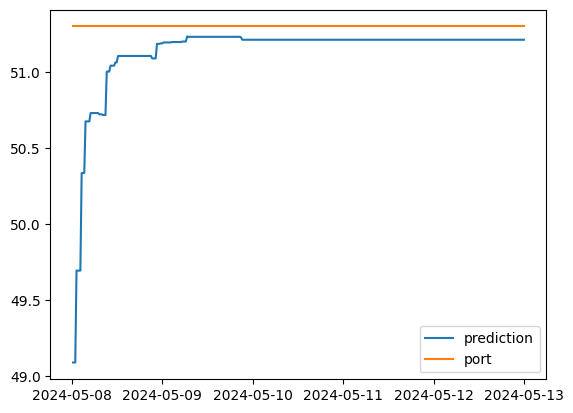

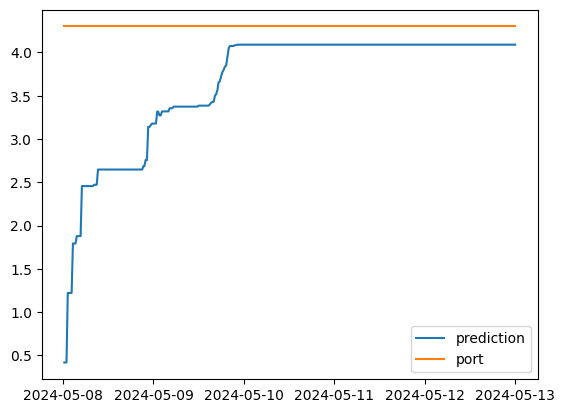

In [83]:
vessels = vessels_scheduels

vessel = vessels[9]
vessel_data_test = test_df[test_df['vesselId'] == vessel]
vessel_data_train = train_df[train_df['vesselId'] == vessel]

#plt.plot(vessel_data_train['time'],vessel_data_train['latitude'])
#plt.plot(vessel_data_train['time'],vessel_data_train['portLatitude'], label = 'port')

plt.plot(vessel_data_test['time'],vessel_data_test['latitude_predicted'], label = 'prediction')
plt.plot(vessel_data_test['time'],vessel_data_test['portLatitude'], label = 'port')
plt.legend()

plt.figure()
#plt.plot(vessel_data_train['time'],vessel_data_train['longitude'])
#plt.plot(vessel_data_train['time'],vessel_data_train['portLongitude'], label = 'port')
plt.plot(vessel_data_test['time'],vessel_data_test['longitude_predicted'], label =  'prediction')
plt.plot(vessel_data_test['time'],vessel_data_test['portLongitude'], label = 'port')
plt.legend()



## Feature engineering

In [8]:

le_vesselid = LabelEncoder()
le_vesselid.fit(train_df['vesselId'])
train_df['vesselId'] = le_vesselid.transform(train_df['vesselId'])
test_df['vesselId'] =  le_vesselid.transform(test_df['vesselId'])

le_shippingLineId = LabelEncoder()
le_shippingLineId.fit(train_df['shippingLineId'])
train_df['shippingLineId'] = le_shippingLineId.transform(train_df['shippingLineId'])
test_df['shippingLineId'] = le_shippingLineId.transform(test_df['shippingLineId'])


le_portid = LabelEncoder()
le_portid.fit(train_df['portId'])
train_df['portId'] = le_portid.transform(train_df['portId'])

train_df['navstat'] = pd.Categorical(train_df['navstat']).codes

#train_df = train_df.dropna()

In [ ]:
train_df = train_df.sort_values(by = 'vesselId', kind = 'stable')
display(train_df)
display(test_df.sort_values(by = 'vesselId', kind = 'stable'))

### Data visualization

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

train_df['longitude'].plot(kind='hist', bins=400, ax=axes[0,0], title='Histogram longitude', xlabel = 'longitude')

train_df['latitude'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram latitude', xlabel = 'latitude')

train_df['longitude_portId'].plot(kind='hist', bins=400, ax=axes[1,0], title='Histogram longitude portId', xlabel= 'longitude portId')

train_df['latitude_portId'].plot(kind='hist', bins=400, ax=axes[1,1], title='Histogram latitude portId', xlabel = 'latitude portId')

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

train_df['vesselId'].plot(kind='hist', bins=400, ax=axes[0,0], title='Histogram vesselId', xlabel = 'vesselId')

train_df['portId'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram portId', xlabel = 'portId')

train_df['shippingLineId'].plot(kind='hist', bins=400, ax=axes[1,0], title='Histogram shippingLineId', xlabel= 'shippingLineId')

train_df['navstat'].plot(kind='hist', bins=29, ax=axes[1,1], title='Histogram navstat', xlabel= 'navstat')


plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

train_df['sog'].plot(kind='hist', bins=40, ax=axes[0,0], title='Histogram SOG', xlabel = 'SOG')

train_df['cog'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram COG', xlabel = 'COG')

train_df['heading'].plot(kind='hist', bins=360, ax=axes[1,0], title='Histogram heading', xlabel = 'Heading')

train_df['rot'].plot(kind='hist', bins=360, ax=axes[1,1], title='Histogram ROT', xlabel= 'ROT')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))


train_df['second'].plot(kind = 'hist', bins = 60, ax= ax[0,0], title = f'Histogram second', xlabel = f'second')

train_df['minute'].plot(kind = 'hist', bins = 60, ax= ax[0,1], title = f'Histogram minute', xlabel = f'minute')

train_df['hour'].plot(kind = 'hist', bins = 24, ax= ax[1,0], title = f'Histogram hour', xlabel = f'hour')

train_df['day_of_week'].plot(kind = 'hist', bins = 7, ax= ax[1,1], title = f'Histogram day_of_week', xlabel = f'day of week')

train_df['day'].plot(kind = 'hist', bins = 32, ax= ax[2,0], title = f'Histogram day', xlabel = f'day')

train_df['month'].plot(kind = 'hist', bins = 5, ax= ax[2,1], title = f'Histogram month', xlabel = f'month')

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))

train_df['length'].plot(kind = 'hist', bins = 60, ax= ax[0], title = f'Histogram breadth', xlabel = f'length')

train_df['GT'].plot(kind = 'hist', bins = 60, ax= ax[1], title = f'Histogram GT', xlabel = f'GT')

print(f'Number of Nan in lenght: {sum(np.isnan(train_df['length']))}')
print(f'Number of GT in lenght: {sum(np.isnan(train_df['GT']))}')
plt.tight_layout()
plt.show()

In [ ]:
train_df['cog_rad'] = np.pi/180*train_df['cog']
train_df['sog_long'] = 1/60 * train_df['sog']*np.sin(train_df['cog_rad'])*np.cos(train_df['longitude'])
train_df['sog_lat'] = 1/60* train_df['sog']*np.cos(train_df['cog_rad'])

train_df['sog_long'].plot(kind =  'hist', bins = 360)
plt.figure()
train_df['sog_lat'].plot(kind =  'hist', bins = 360)

In [ ]:
display(train_df.columns)

In [ ]:
shippingLineId1 = train_df['shippingLineId'].unique()
for i in range(len(shippingLineId1)):
    data_shippingLineId = train_df[train_df['shippingLineId'] == shippingLineId1[i]]
    data_shippingLineId = data_shippingLineId.sort_values(by = 'time')
    start = -1000
    stop = -1
    plt.figure(figsize = (20,4))
    plt.plot(data_shippingLineId['time'][start:stop], data_shippingLineId['latitude_portId'][start:stop])
    plt.plot(data_shippingLineId['time'][start:stop], data_shippingLineId['longitude_portId'][start:stop])


In [ ]:
vessels = train_df['vesselId'].unique()

plt.rcParams['lines.linewidth'] = 0.5
vessel = vessels[0]
for vessel in vessels[100:110]:
    vessel_data = train_df[train_df['vesselId'] == vessel]
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
    ax[0].plot(vessel_data['time'], vessel_data['latitude_portId'], 'r-', label = 'portId')
    ax[0].plot(vessel_data['time'], vessel_data['latitude_portId'], 'r.')
    ax[0].plot(vessel_data['time'], vessel_data['latitude'], 'b-', label = 'latitude')
    ax[0].plot(vessel_data['time'], vessel_data['latitude'], 'b.')
    ax[0].legend()

    ax[1].plot(vessel_data['time'], vessel_data['longitude_portId'], 'r-', label = 'portId')
    ax[1].plot(vessel_data['time'], vessel_data['longitude_portId'], 'r.')
    ax[1].plot(vessel_data['time'], vessel_data['longitude'], 'b-', label = 'longitude')
    ax[1].plot(vessel_data['time'], vessel_data['longitude'], 'b.')
    ax[1].legend()

In [ ]:
shippingLineId = train_df['shippingLineId'].unique()
train_df = train_df.sort_values(by = 'time', kind = 'stable')
plt.rcParams['lines.linewidth'] = 0.5
for shippingLine in shippingLineId:
    vessel_data = train_df[train_df['shippingLineId'] == shippingLine][-1000:]
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
    ax[0].plot(vessel_data['time'], vessel_data['latitude_portId'], 'r-', label = 'portId')
    ax[0].plot(vessel_data['time'], vessel_data['latitude_portId'], 'r.')
    ax[0].plot(vessel_data['time'], vessel_data['latitude'], 'b-', label = 'latitude')
    ax[0].plot(vessel_data['time'], vessel_data['latitude'], 'b.')
    ax[0].legend()

    ax[1].plot(vessel_data['time'], vessel_data['longitude_portId'], 'r-', label = 'portId')
    ax[1].plot(vessel_data['time'], vessel_data['longitude_portId'], 'r.')
    ax[1].plot(vessel_data['time'], vessel_data['longitude'], 'b-', label = 'longitude')
    ax[1].plot(vessel_data['time'], vessel_data['longitude'], 'b.')
    ax[1].legend()

In [ ]:
train_df = train_df.sort_values(by = 'vesselId', kind = 'stable')
train_df['latitude_1'] = train_df['latitude'].shift(1)
train_df['longitude_1'] = train_df['longitude'].shift(1)

train_df['latitude_2'] = train_df['latitude'].shift(2)
train_df['longitude_2'] = train_df['longitude'].shift(2)

train_df['latitude_3'] = train_df['latitude'].shift(3)
train_df['longitude_3'] = train_df['longitude'].shift(3)

train_df['latitude_portId_1'] = train_df['latitude_portId'].shift(1)
train_df['longitude_portId_1'] = train_df['longitude_portId'].shift(1)

train_df['latitude_portId_2'] = train_df['latitude_portId'].shift(2)
train_df['longitude_portId_2'] = train_df['longitude_portId'].shift(2)

train_df['latitude_portId_3'] = train_df['latitude_portId'].shift(3)
train_df['longitude_portId_3'] = train_df['longitude_portId'].shift(3)

train_df['sog_1'] = train_df['sog'].shift(1)
train_df['heading_1'] = train_df['heading'].shift(1) 
train_df['cog_1'] = train_df['sog'].shift(1)

train_df['sog_2'] = train_df['sog'].shift(2)
train_df['heading_2'] = train_df['heading'].shift(2) 
train_df['sog_2'] = train_df['sog'].shift(2)

train_df['sog_3'] = train_df['sog'].shift(3)
train_df['heading_3'] = train_df['heading'].shift(3) 
train_df['cog_3'] = train_df['sog'].shift(3)

train_df = train_df.dropna()
display(train_df)

In [ ]:
shippinglines = schedules_df['shippingLineId'].unique()

data_shippingline0 = schedules_df[schedules_df['shippingLineId'] == shippinglines[0]]
start = 100
stop = 300


plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[0]}')
plt.plot(data_shippingline0['portLatitude'][start:stop], label = 'latitude')
plt.plot(data_shippingline0['portLongitude'][start:stop], label = 'longitude')
plt.legend()

data_shippingline1 = schedules_df[schedules_df['shippingLineId'] == shippinglines[1]]

plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[1]}')
plt.plot(data_shippingline1['portLatitude'][start:stop], label =  'latitude')
plt.plot(data_shippingline1['portLongitude'][start:stop], label = 'longitude')
plt.legend()

data_shippingline2 = schedules_df[schedules_df['shippingLineId'] == shippinglines[2]]

plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[2]}')
plt.plot(data_shippingline2['portLatitude'][start:stop], label =  'latitude')
plt.plot(data_shippingline2['portLongitude'][start:stop], label = 'longitude')
plt.legend()

data_shippingline3 = schedules_df[schedules_df['shippingLineId'] == shippinglines[3]]

plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[3]}')
plt.plot(data_shippingline3['portLatitude'][start:stop], label =  'latitude')
plt.plot(data_shippingline3['portLongitude'][start:stop], label = 'longitude')
plt.legend()

data_shippingline4 = schedules_df[schedules_df['shippingLineId'] == shippinglines[4]]

plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[4]}')
plt.plot(data_shippingline4['portLatitude'][start:stop], label =  'latitude')
plt.plot(data_shippingline4['portLongitude'][start:stop], label = 'longitude')
plt.legend()


In [ ]:
features = ['minute', 'day_of_week', 'hour','vesselId', 'shippingLineId', 'latitude_portId_1',
             'longitude_portId_1', 'latitude_1' , 'longitude_1', 'heading_1', 'sog_1', 'cog_1',  'length','GT']
targets = ['latitude', 'longitude', 'latitude_portId', 'longitude_portId', 'heading', 'sog', 'cog']

train_df = train_df.sort_index()
X = train_df[features]
y = train_df[targets]


params = {
    'objective': 'reg:squarederror',
    'max_depth': 7,
    'eta':  0.01,
}

dtrain = xgb.DMatrix(X, label = y)
evals = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_boost_round= 500, evals = evals, verbose_eval= 10)


In [ ]:
lat_pred = []
long_pred = []
lat_portId_pred = []
long_portId_pred = []
head_pred = []
sog_pred = []
cog_pred = []
predictions = []
last_position = {}

for index, row in test_df.iterrows():
    vessel = row['vesselId']
    if(vessel in last_position):
        lat,long, lat_portId, long_portId, heading, sog, cog = last_position[vessel]
    else:
        lat = np.array(train_df[train_df['vesselId']  == vessel]['latitude'])[-1] 
        long = np.array(train_df[train_df['vesselId']  == vessel]['longitude'])[-1]
        lat_portId = np.array(train_df[train_df['vesselId']  == vessel]['latitude_portId'])[-1]
        long_portId = np.array(train_df[train_df['vesselId']  == vessel]['longitude_portId'])[-1]
        heading = np.array(train_df[train_df['vesselId']  == vessel]['heading'])[-1]
        sog = np.array(train_df[train_df['vesselId']  == vessel]['sog'])[-1]
        cog = np.array(train_df[train_df['vesselId']  == vessel]['cog'])[-1]    
            
    print(index, end = '\r')
    X_data = {'minute':row['minute'] , 'day_of_week':row['day_of_week'], 'hour':row['hour'], 'vesselId': row['vesselId'], 
              'shippingLineId': row['shippingLineId'], 'latitude_portId_1':lat_portId, 'longitude_portId_1':long_portId, 
              'latitude_1':lat, 'longitude_1':long, 'heading_1':heading, 'sog_1':sog, 'cog_1':cog, 'length': row['length'], 'GT':row['GT']}
    X = pd.DataFrame(data = X_data, index = [0])
    dtest = xgb.DMatrix(X)
    prediction = model.predict(dtest)
    last_position[vessel] = prediction[0]   
    lat_pred.append(prediction[0][0])
    long_pred.append(prediction[0][1])
    lat_portId_pred.append(prediction[0][2])
    long_portId_pred.append(prediction[0][3])
    head_pred.append(prediction[0][4])
    sog_pred.append(prediction[0][5])
    cog_pred.append(prediction[0][6])
    predictions.append(prediction[0])

In [ ]:
predictions = np.array(predictions)

latitudes_predicted = predictions[:,0] 
longitudes_predicted = predictions[:,1] 

test_df['longitude_predicted'] = long_pred
test_df['latitude_predicted'] = lat_pred
test_df['longitude_portId_predicted'] = long_portId_pred
test_df['latitude_portId_predicted'] = lat_portId_pred

vesselId = 90
vessel = test_df['vesselId'].unique()[vesselId]

vessel_data_train = train_df[train_df['vesselId'] == vessel]
vessel_data_test = test_df[test_df['vesselId'] == vessel]

N = len(vessel_data_train['longitude'])
M = len(vessel_data_test['longitude_predicted'])

index_train = np.linspace(0, N,N)
index_test = np.linspace(N, N+M,M)

plt.plot(index_test, vessel_data_test['longitude_predicted'], 'r,', label = 'long_pred')
plt.plot(index_test, vessel_data_test['latitude_predicted'], 'b,', label = 'lat_pred')
plt.legend()
plt.figure()
plt.plot(index_train, vessel_data_train['longitude'], label = 'long')
plt.plot(index_test, vessel_data_test['longitude_predicted'], label = 'long_pred')
plt.plot(index_train, vessel_data_train['latitude'],label = 'lat')
plt.plot(index_test, vessel_data_test['latitude_predicted'], label = 'lat_pred')
plt.legend()

plt.figure()
plt.plot(index_train, vessel_data_train['longitude_portId'], label = 'long portId')
plt.plot(index_test, vessel_data_test['longitude_portId_predicted'], label = 'long portId pred')
plt.plot(index_train, vessel_data_train['latitude_portId'],label = 'lat')
plt.plot(index_test, vessel_data_test['latitude_portId_predicted'], label = 'lat portId pred')
plt.legend()


In [45]:
submission = pd.DataFrame(test_df[['ID','longitude_predicted', 'latitude_predicted']])
submission.to_csv('submission_22_10.csv', index = False)

In [ ]:

from geopy.distance import geodesic
submission_best = pd.read_csv('submission_16_10.csv')
submission_today = pd.read_csv('submission_22_10.csv')
latitude_best = submission_best['latitude_predicted']
longitude_best = submission_best['longitude_predicted']
latitudes_today = submission_today['latitude_predicted']
longitudes_today = submission_today['longitude_predicted']
distances = []
weights = test_df['scaling_factor']
for i in range(len(longitude_best)):
    distance = geodesic((latitude_best[i], longitude_best[i]), 
                        (latitudes_today[i], longitudes_today[i])).meters
    distances.append(distance*weights[i])

print((np.mean(distances)) /1000)
    

In [ ]:
display(train_df.columns)

In [ ]:
vessels = test_df['vesselId'].unique()
vessel = vessels[4]

vessel_data = train_df[train_df['vesselId'] == vessel]

N = int(len(vessel_data)*0.9)

features = ['second', 'minute', 'hour', 'day', 'day_of_week', 'month', 'latitude_1', 'longitude_1', 'latitude_portId_1', 'longitude_portId_1', 'sog_1', 'heading_1']
targets = ['latitude', 'longitude', 'latitude_portId', 'longitude_portId', 'sog', 'heading']

X_train = vessel_data[features][:N]
y_train = vessel_data[targets][:N]

X_test = vessel_data[features][N:]
y_test = vessel_data[targets][N:].reset_index()



params = {
    'objective': 'reg:squarederror',
    'max_depth': 7,
    'eta':  0.01,
}

dtrain = xgb.DMatrix(X_train, label = y_train)
evals = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_boost_round= 500, evals = evals, verbose_eval= 100)
dtest = xgb.DMatrix(X_test)
prediction = model.predict(dtest)
prediction_df = pd.DataFrame(prediction, columns = targets)

plt.plot(vessel_data['latitude'])
plt.plot(vessel_data['longitude'])

In [ ]:
last_posistion = [y_train['latitude'].iloc[-1], y_train['longitude'].iloc[-1],
                   y_train['latitude_portId'].iloc[-1], y_train['longitude_portId'].iloc[-1],
                     y_train['sog'].iloc[-1], y_train['heading'].iloc[-1]]
lat_pred = [] 
long_pred = [] 
lat_port_pred = []
long_port_pred = []
for index, row in X_test.iterrows():

    X_data = {'second':row['second'], 'minute':row['minute'] , 'hour':row['hour'], 'day':row['day'], 'day_of_week':row['day_of_week'], 'month':row['month'],
               'latitude_1':last_posistion[0], 'longitude_1':last_posistion[1], 
               'latitude_portId_1':last_posistion[2], 'longitude_portId_1':last_posistion[3],
               'sog_1':last_posistion[4], 'heading_1':last_posistion[5]}
    X = pd.DataFrame(data = X_data, index = [0])
    dtest = xgb.DMatrix(X)
    prediction = model.predict(dtest)[0]
    last_posistion = prediction
    lat_pred.append(prediction[0])
    long_pred.append(prediction[1])
    lat_port_pred.append(prediction[2])
    long_port_pred.append(prediction[3])

prediction_df = pd.DataFrame({'latitude':lat_pred, 'longitude':long_pred, 'latitude_portId':lat_port_pred, 'longitude_portId':long_port_pred})
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,10))

ax[0,0].set_title(f'latitude')
ax[0,0].plot(prediction_df['latitude'], label = 'predicted')
ax[0,0].plot(y_test['latitude'])
ax[0,0].legend()

ax[0,1].set_title(f'longitude')
ax[0,1].plot(prediction_df['longitude'], label = 'predicted')
ax[0,1].plot(y_test['longitude'])
ax[0,1].legend()

ax[1,0].set_title(f'latitude')
ax[1,0].plot(prediction_df['latitude_portId'], label = 'predicted')
ax[1,0].plot(y_test['latitude_portId'])
ax[1,0].legend()

ax[1,1].set_title(f'longitude')
ax[1,1].plot(prediction_df['longitude_portId'], label = 'predicted')
ax[1,1].plot(y_test['longitude_portId'])
ax[1,1].legend()

In [ ]:
vessels = test_df['vesselId'].unique()
vessel = vessels[5]

vessel_data = train_df[train_df['vesselId'] == vessel]

N = int(len(vessel_data)*0.9)

features = ['second', 'minute', 'hour', 'day', 'day_of_week', 'month', 'latitude_1', 'longitude_1', 'latitude_portId_1', 'longitude_portId_1']
targets = ['latitude', 'longitude', 'latitude_portId', 'longitude_portId']

X_train = vessel_data[features][:N]
y_train = vessel_data[targets][:N]

X_test = vessel_data[features][N:]
y_test = vessel_data[targets][N:].reset_index()



params = {
    'objective': 'reg:squarederror',
    'max_depth': 7,
    'eta':  0.01,
}

dtrain = xgb.DMatrix(X_train, label = y_train)
evals = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_boost_round= 500, evals = evals, verbose_eval= 100)
dtest = xgb.DMatrix(X_test)
prediction = model.predict(dtest)
prediction_df = pd.DataFrame(prediction, columns = targets)

plt.plot(prediction_df['latitude'])
plt.plot(y_test['latitude'])

plt.plot(prediction_df['longitude'])
plt.plot(y_test['longitude'])